# **Heritage**

**...an AI query system for The Nigerian Peoples, their Pre-historic Arts, & Cultures.**

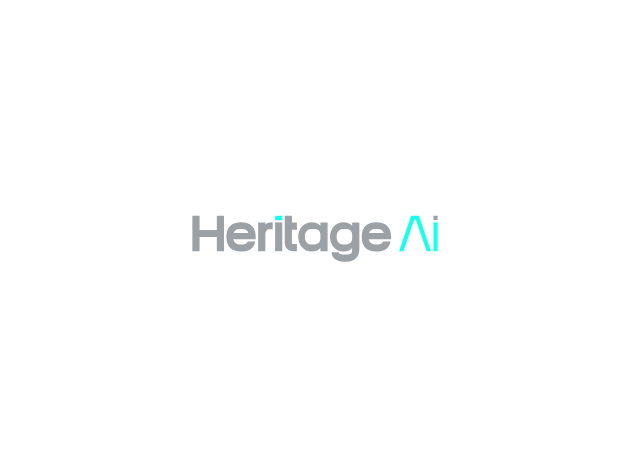

## Before I Begin

Hi! I'm  [🅱🅻🅰🆀](https://www.linkedin.com/in/chinonsoodiaka/).

This is my submission for the ```Agentscraft Hackathon``` 2024.


A few things you should know...

* This solution is an agentic chatbot with integrated image generation capabilities, designed to provide a rich, interactive experience. The workflow leverages ```LangGraph``` components, along with ```Tavily``` and a ```Gradio tool```, creating a seamless system for user interactions.

* The best part? This system operates at ```zero``` cost — no additional expenses required. However, to unlock its full potential, you'll need a few API keys to enable all features.

* One of the key advantages of this setup is its flexibility. The theme or use case of this chatbot can be effortlessly customized. While it's currently focused on ```Heritage``` you could easily adapt it to something entirely different — like "Space" — as long as you have a knowledge base that supports the new theme. Each component is modular and can be swapped out for alternatives without disrupting the overall structure.

With that said, let’s dive into it!

## Heritage Architecture

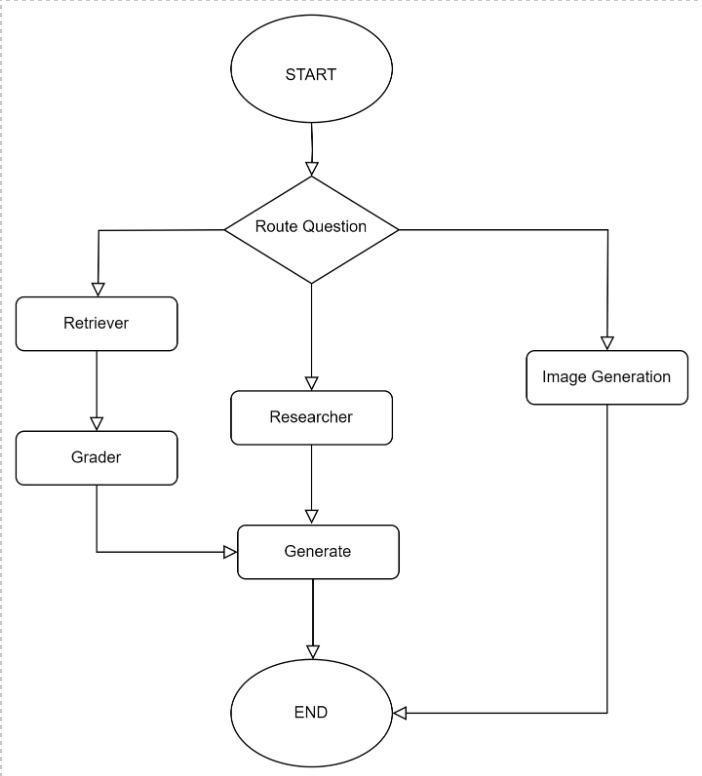

The core functionality of this system revolves around routing user queries to one of three branches: the RAG (Retrieval-Augmented Generation) branch, the internet branch, or the image generation branch.

* RAG branch handles queries that might be answered by data stored in the vector database.
* Internet branch is activated when the query isn’t found in the database and requires online information.
* Image generation branch manages queries that involve visualization or image-based responses.

A routing node directs each query to the appropriate branch based on its nature.

* When a query is routed to the RAG branch, the retriever node intercepts it, using the query to search the database and retrieve documents with similar meaning. These retrieved documents then go through the grader node, which evaluates their relevance. Only the most contextually relevant documents are passed on as context to the generator node. Finally, the generator node crafts a response to the user query based on the knowledge gathered from previous steps.
* When a query is directed to the Internet branch, the system initiates a research process to gather relevant documents from the web based on the query. These documents are then passed to the Generator node to provide additional context and produce a response.
* When a query is directed to the Image Generation branch, it triggers a request to this live [Gradio text-to-image tool](https://huggingface.co/spaces/prithivMLmods/Text-to-Image) hosted on Hugging Face Spaces. The generated image path is returned to the user for direct access to the result.


This structure forms the core of the system. However, to create a truly robust solution, additional points of action and conditional logic are required to enhance functionality and flexibility.

I will start by building out the different components of the application.

## Install and Import Python Packages

In [1]:
! pip install -qU \
    langchain-qdrant==0.1.4 \
    langchain-huggingface==0.1.2 \
    pymupdf==1.24.13 \
    langchain_community==0.3.5 \
    langgraph==0.2.44 \
    tavily-python==0.5.0 \
    gradio==5.4.0 \
    gradio-client==1.4.2 \
    langchain-groq==0.2.1


In [32]:
# Standard
from datetime import datetime, date
import os
import requests
import getpass
from uuid import uuid4
from typing import List

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image, display

# LangChain Core
from langchain.prompts import PromptTemplate
from langchain.schema import AIMessage
from langchain.retrievers import EnsembleRetriever
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

# LangChain Community 
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader, AsyncChromiumLoader, PyPDFLoader
from langchain_community.document_transformers import BeautifulSoupTransformer
from langchain_community.retrievers import SVMRetriever, TavilySearchAPIRetriever

# LangChain-Specialized
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_groq import ChatGroq
from gradio_client import Client

# 6. Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from qdrant_client.http.exceptions import UnexpectedResponse

# Graph 
from langgraph.graph import MessagesState, StateGraph, END

Send your Api Keys to the environment.

In [ ]:
os.environ["QDRANT_API_KEY"] = getpass.getpass("Enter your QDRANT API KEY: ")
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## The Embeddings Model

For this quick proof of concept, I chose a model from Hugging Face. 

I wanted a reliable, open-source embeddings model and ultimately decided on ```all-mpnet-base-v2```, but you can explore other options [here](https://huggingface.co/spaces/mteb/leaderboard).

In [4]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## Qdrant - Vector Database Creation & Setup.



In [ ]:
# Initialize Qdrant client

client = QdrantClient(":memory:")

# Check if the collection exists
collection_name = "heritage"
print("Vector store does not exist. Creating collection...")
client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=768, distance=Distance.COSINE)
    )

# Initialize the vector store
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

print("Vector store is ready.")

Vector store does not exist. Creating collection...
Vector store is ready.


* For my vectors configuration, I am using ```size=768``` because my embeddings model from Huggingface has dimension size equal to 768.
* For my indexing strategy, I will be using Cosine similarity since I will be making semantic retrievals.

## Data Ingestion

I gathered several academic PDFs on the diverse arts and cultures of Nigeria. Due to the 10MB file size limit for this hackathon, I couldn’t include as many documents as I would have liked. Currently, I have four PDFs stored in the /data directory:

* ```history of nigerian traditional arts.pdf```
* ```Nigerian arts - a short history by moses and osinachi.pdf```
* ```NigerianCultureandTraditions.pdf```
* ```perspectives on nigerian peoples and culture.pdf```

With all files organized in the same directory, loading the data using LangChain will be straightforward.

In [6]:
loader = DirectoryLoader('./data/', glob="**/*.pdf", show_progress=True, loader_cls=PyMuPDFLoader)

In [7]:
docs = loader.load()
len(docs)

100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


187

Great, the data has been loaded successfully!

When ingesting documents into the vector store, I prefer to add unique ```id```s to each document for easier management and retrieval.

In [8]:
uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

['fbc4b112-122f-4d20-8c7d-b8208784be75',
 'fe69f57a-cdcd-4249-a3a1-d8946fb550e3',
 '0938648e-98ac-4df5-b938-be82528a6373',
 '1562f456-9273-449c-97bf-80c55020a20f',
 '36f32e5e-8ab4-48d0-a3f3-21630c6395f0',
 'e41bdd4c-b24e-4ca6-ad3f-9f447121a401',
 '3ce936ab-fd28-47a2-9d08-da93d1006bcf',
 '1f523593-5599-4cc8-9761-210ec984f145',
 '6fd61196-2d70-43c3-bc8c-7096aedb9817',
 'd6ab2672-dcbd-4327-966d-6d8cecf9b1ae',
 '890a0cf2-e5c1-4907-afb1-930e325859a8',
 '65539b50-83e5-480d-b718-7f631be226fb',
 '106cb408-83e0-4456-aca7-f5c94eadc724',
 '563c33cb-faf1-4778-86c7-d985cc615796',
 '18c1309a-ae79-4953-820f-489c7b0d14e4',
 'e66769b8-8dee-43c9-97cc-8e6b00c07d0b',
 '5976a522-9891-479b-aa9e-8ffda9f1eaf3',
 '8ec84df2-3be3-4b52-8f00-1db5cb695f8a',
 '8c1b407e-f9b4-4c02-85dc-e5adc8a6ab9c',
 'a35b23fb-b7c8-48a8-9fc0-057427a1b6b8',
 'd1aa1913-2d28-4cbf-a039-3eb836b7df88',
 'c25627a5-c409-4634-a4c4-b4c2dc836df5',
 'fc9f3f16-09da-4c28-9f00-1bb9b2dcac80',
 '641e1d34-1068-4dbc-ac42-c266decc4768',
 '83e388a0-2168-

Query the Database...

In [9]:
results = vector_store.similarity_search_with_score(
    query="ife art form", k=1
)
for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

* [SIM=0.439336] Moses Onugadi Njoku & Osinachi Immaculeta Okafor: Nigeria Art : A Short History 
 
117 
 
due to the presence of court clerks and historians that record the 
daily activities of the king and the kingdom. Therefore, court art 
was predominant in Ife kingdom with most of the themes addressed 
to the majesty. One notable characteristic of the Ife art is the 
emphasis on the size of the head as being the center of knowledge, 
symbol of ego and destiny and so on. The Ife artists therefore do not 
observe the rules of proportion in producing their figures but rather 
the heads usually are made a little larger than the rest of the body; 
sometimes in the ratio of 1:4. Another notable characteristic of the 
Ife art is in the use of small holes to indicate beards and hairlines of 
the masks and faces, and the presence of prominent scarification 
lines running vertically across the whole face.  
 
The Ifes were also adept in their mastery of copper and its 
alloys and they produ

Create the retriever...

In [10]:
# Create retrievers
similarity_retriever = vector_store.as_retriever(search_kwargs={"k": 5})
svm_retriever = SVMRetriever.from_documents(docs, embeddings)

# Create ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[similarity_retriever, svm_retriever],
    weights=[0.7, 0.3]) 

In [11]:
ensemble_retriever.invoke("Ife art")

[Document(metadata={'source': 'data\\Nigerian arts - a short history by moses and osinachi.pdf', 'file_path': 'data\\Nigerian arts - a short history by moses and osinachi.pdf', 'page': 8, 'total_pages': 20, 'format': 'PDF 1.4', 'title': 'Microsoft Word - FORMATED 6. VOL. 13. NO 2.doc', 'author': 'Tracie1', 'subject': '', 'keywords': '', 'creator': 'PScript5.dll Version 5.2.2', 'producer': 'GPL Ghostscript 8.71', 'creationDate': "D:20210920211322+01'00'", 'modDate': "D:20210920211322+01'00'", 'trapped': '', '_id': '890a0cf2-e5c1-4907-afb1-930e325859a8', '_collection_name': 'heritage'}, page_content='Moses Onugadi Njoku & Osinachi Immaculeta Okafor: Nigeria Art : A Short History \n \n117 \n \ndue to the presence of court clerks and historians that record the \ndaily activities of the king and the kingdom. Therefore, court art \nwas predominant in Ife kingdom with most of the themes addressed \nto the majesty. One notable characteristic of the Ife art is the \nemphasis on the size of the 

## Where we are...

* Data loaded, 
* index created, and 
* retriever set up. 

Now, it's time for the design process.

## Components: Tools, Nodes, Conditional Edges, Schema.

### Schema

I will be using the ```MessagesState``` schema but I will customize it to include a variable ```documents```.

The ```documents``` variable will receive data from either the retriever or the web search function, as these are the only two nodes capable of providing context to the generator.

In [12]:
class CustomMessagesState(MessagesState):
    documents: List[str]

### Nodes

These are simply **action points** on the graph.

* **A Generator**

    This node generates an answer to a user question based on provided context, utilizing a language model to respond accurately and concisely.

    Here's how it works:

    * Extracts the question and context from the state object. The user’s question is retrieved from ```state["messages"]```. Relevant documents (context) are retrieved from ```state["documents"]```.
    * Defines a structured prompt to guide the response. 
    * Combines the prompt, LLM, and output parser - ```StrOutputParser```, in a processing chain to generate the answer.
    * Executes the chain by passing the user question and context into rag_chain, resulting in a direct, relevant answer.
    * Returns the generated answer wrapped in an AIMessage format, suitable for the next stages in the workflow.

In [13]:
def generate_node(state: CustomMessagesState) -> dict:
    """
    Generate an answer to a question based on provided context using the Groq model.

    Args:
        state (MessagesState): The state containing messages and context.

    Returns:
        dict: A dictionary containing the generated answer in AIMessage format.
    """

    print("RESPONDING...") 
    # Retrieve the question from the state
    question = state["messages"][0].content

    # Retrieve the documents from the last message in the state
    documents = state["documents"]
    formatted_documents = documents

    # Define the prompt
    prompt = PromptTemplate(
        template="""Answer the question below based only on the provided context. Avoid responses like 'According to the provided context...' or 
    'Based on the provided context...' — simply answer directly. If the context does not contain enough information, respond with 'I don't know.'

Question: {messages}
Context: {documents}""",
        input_variables=["messages", "documents"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

    # Create the chain for generating the answer
    rag_chain = prompt | llm | StrOutputParser()

    # Invoke the chain with the question and formatted documents
    result = rag_chain.invoke({"messages": question, "documents": formatted_documents})

    # Wrap the result in an AIMessage to meet the required format
    return {"messages": [AIMessage(content=result)]}

* **A Retriever**

    This node is designed to retrieve relevant documents related to Nigerian arts and culture from a vector database based on user queries. I already created the "tool" for this - ```ensemble_retriever``` - but to use it in my graph as a query-database action point, I need to convert it to a specific form.

    Here's how it works:

    * The original user query is extracted from the MessagesState.

    * The query is refined by passing it through an *improve-query* prompt and then invoking the language model, resulting in a more contextually appropriate query.
    * The improved query is used to call the ensemble_retriever, which searches the vector database for documents related to Nigerian culture.
    * Retrieved documents are extracted and formatted as a list.

In [14]:
def retriever_node(state: CustomMessagesState) -> dict:
    """
    Retrieve relevant documents based on the user question, refining it to align with the Nigerian people's arts and culture theme.

    Args:
        state (MessagesState): The state containing the user question.
        retriever: The retriever instance for obtaining relevant documents.

    Returns:
        dict: A dictionary containing the retrieved documents.
    """
    print("RETRIEVING DOCUMENTS...")
    
    # Define the query improvement prompt to align with Nigerian arts and culture
    improve_query_prompt = PromptTemplate(
        template="""You are an expert in refining search queries to enhance relevance and clarity, with a focus on Nigerian people's arts and culture. 
        When provided with a user query, broaden or clarify it to fully capture this theme, even if the user’s original question is brief or specific. 
        Ensure the improved query provides context about Nigerian cultural heritage. This query should be brief, straight-to-the-point, simple sentence.

        Original Query:
        {messages}

        Improved Query:""",
        input_variables=["messages"]
    )

    # Initialize the Groq LLM for query improvement
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
    
    # Get the original user question from the state
    original_query = state["messages"][0].content
    
    # Improve the query
    formatted_prompt = improve_query_prompt.format(messages=original_query)
    response = llm.invoke(formatted_prompt)
    improved_query = response.content  # Clean up the response text
    
    # Print the improved query (for debugging/logging purposes)
    print(f"Improved Query: {improved_query}")
    
    # Retrieve relevant documents using the improved query
    docs = ensemble_retriever.invoke(improved_query)
    documents = [doc.page_content for doc in docs]
    print(f"Retrieved documents: {documents}")
    
    # Return the retrieved documents as a list in a dictionary with 'documents' key
    return {"documents": documents}

* **Grader**

    This node assesses the relevance of retrieved documents to the user’s question, ensuring ONLY relevant documents proceed in the workflow. Here's how it works:

    * User question and retrieved documents are accessed from the MessagesState.

    * The user question is retrieved as the reference for evaluating document relevance. Each document is graded for relevance through a prompt-based LLM assessment.

    * A grading prompt instructs the model to compare the semantic similarity of each document to the user’s question. The model then assigns a binary   score: ```YES``` for relevant and ```NO``` for irrelevant.
    Only documents marked as relevant (```YES```) are retained.

    * Documents deemed relevant are concatenated into a single text ```docmnt``` for further analysis.
    An analyzer prompt evaluates if the retained document(s) fully address the user’s question.

    * Using a follow-up prompt, the model assesses if the content of ```docmnt``` is comprehensive enough to answer the question in full.
    
    Final Routing Decision:

    * If the document fully answers the question (```YES```), the node outputs generate_node, proceeding to generate a response.
    * If not (```NO```), the node outputs researcher, directing the query for additional research or alternative processing.

In [15]:
def grader_node(state: CustomMessagesState) -> dict:
    """
    Grade the relevance of retrieved documents to a user question.

    Args:
        state (MessagesState): The state containing the user question and retrieved documents.

    Returns:
        dict: A dictionary containing either 'researcher' if NO count exceeds 2,
              or 'generate_node' if the documents are mostly relevant.
    """

    # Define the prompt for grading
    grader_prompt = PromptTemplate(
        template="""You are a grader assessing the relevance of a retrieved document to a user question.

        Here is the retrieved document:
        {document}

        Here is the user question:
        {messages}

        To assess the relevance of the document to the question, please use semantic similarity to compare the meaning of the document and the question. If the document contains information that is semantically similar to the user question, grade it as relevant. Do not be stringent with the keywords. The goal is to filter out erroneous retrievals.

        Give a binary score 'YES' to indicate that the document is relevant to the question, or 'NO' to indicate that the document is NOT relevant to the question.

        Provide the binary score as plain text with no preamble or explanation.
        """,
        input_variables=["messages", "document"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
    
    print("GRADING RETRIEVED DOCUMENTS...") 
    # Get the user question from the state
    question = state["messages"][0]

    # Get the retrieved documents from the last entry in the messages
    documents = state["documents"]  # Assuming the retriever node set this

    no_count = 0
    docmnt = ""
    
    # Loop through each document to grade its relevance
    for doc in documents:
        # Generate the prompt for the current document
        formatted_prompt = grader_prompt.format(messages=question, document=doc)
        
        # Invoke the LLM with the formatted prompt
        response = llm.invoke(formatted_prompt)
        #print(f"GRADE: {response.content.strip().upper()}")
        
        # Check if the response is 'NO' and increment the counter if it is
        if response.content.strip().upper() == 'YES':
            docmnt += doc
    
    # Define the prompt for analyzing
    analyzer_prompt = PromptTemplate(
        template="""You are an analyzer assessing whether a document completely answers a given query.

Document: {document}

Query: {messages}

Carefully examine if the document contains all necessary information to fully answer the question. Avoid relying on keyword similarity; 
only respond 'YES' if the document definitively addresses the question in full. Otherwise, reply 'NO.'

Respond with a simple 'YES' or 'NO' without additional explanation.""",
        input_variables=["messages", "document"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")
    
    print("ANALYZING GRADES...") 

    formatted_prompt = grader_prompt.format(messages=question, document=docmnt)
    # Invoke the LLM with the formatted prompt
    response = llm.invoke(formatted_prompt)
  
        

    if response.content.strip().upper() == 'YES':
        return {"messages": AIMessage(content="generate_node"), "documents":docmnt }

    # If NO count does not exceed 2, return 'generate_node'
    return {"messages": AIMessage(content="researcher")}

* **Off-Topic Response**

    This node acts as a ```Responsible AI guardrail``` to keep user interactions aligned with the intended scope of Nigerian arts, culture, and heritage.

    Here’s how it functions:

    * Generates a message that clearly states the chatbot's focus: The response informs users that the system is dedicated solely to discussions on Nigerian peoples, arts, and culture, setting boundaries on acceptable topics.
    * Appends the off-topic response to the message history in ```state["messages"]```, ensuring continuity in the conversation flow.
    * Returns the updated message state with the off-topic response, providing a courteous yet firm boundary for users who attempt to go outside the chatbot's purpose.

In [16]:
def off_topic_response(state: CustomMessagesState) -> dict:
    """
    Generate an off-topic response using the substitute LLM.

    Args:
        state (MessagesState): The current graph state containing previous messages.

    Returns:
        dict: Updated state with the substitute LLM response.
    """
   
    # Create the off-topic message response
    message = "I'm Heritage; designed by 🅱🅻🅰🆀 to ONLY talk about Nigerian Peoples, Arts, and Culture."

    # Print the message (for debugging purposes)
    #print(message)
    
    # Return the updated state with a new list including the off-topic message
    return {"messages": state["messages"] + [AIMessage(content=message)]}

* **Router**

    This node serves as the Routing Logic for directing user inquiries to the appropriate response branches based on the classification of their questions related to Nigerian arts and culture.

    Here’s how it functions:

    * Question Analysis: The node receives a user query from the state and utilizes a pre-defined prompt template to classify the question into one of four categories: RAG, web_search, image_gen, or off_topic. This classification determines the subsequent action to take.
    * Response Routing: Based on the classification, the node directs the inquiry to the appropriate branch:

        * **Web Search**: If classified as web_search, the node prompts the system to fetch current information online.

        * **RAG**: If classified as RAG, it directs the query to the vector database for historical data retrieval.

        * **Image Generation**: If classified as image_gen, it triggers the image generation process for visual queries.
        
        * **Off-Topic**: If the question is categorized as off_topic, the node informs the user that their inquiry is outside the scope of the chatbot's focus on Nigerian arts and culture. 

In [ ]:
# Define the prompt template for routing questions
prompt = PromptTemplate(
    template=f"""You are an expert at routing user questions to the appropriate data source related to Nigerian Arts and Culture History. 
    Based on the provided question, please classify it into one of the following categories:

1. RAG: Questions related to Nigerian Arts and Culture History (including historical figures, art forms, cultural practices, traditions, etc.).
2. web_search: Questions about Nigerian Arts and Culture History that require up-to-date information and might need to be looked up online.
3. image_gen: Questions involving an image.
4. off_topic: Questions that are personal enquiries, inappropriate comments, or queries unrelated to Nigerian Arts and Culture History.

Examples:
    What is the capital of France? -> "DATASOURCE":"off_topic"
    Show me how an igbo-ukwu artifact looks like -> "DATASOURCE":"image_gen"
    Who was a famous Nigerian painter in the 20th century? -> "DATASOURCE":"RAG"
    What is the current status of Nigerian museums? -> "DATASOURCE":"web_search"
    Can you tell me about Nigerian traditional dances? -> "DATASOURCE":"RAG"
    Who is leading the development of Nigerian contemporary art? -> "DATASOURCE":"web_search"
    What are some notable cultural festivals in Nigeria? -> "DATASOURCE":"RAG"
    Who is a prominent Nigerian sculptor today? -> "DATASOURCE":"web_search"
    How did Nigerian art influence African art as a whole? -> "DATASOURCE":"RAG"
    Generate an image of the Nok culture -> "DATASOURCE":"image_gen"
    When is the next major art exhibition in Nigeria? -> "DATASOURCE":"web_search"
    Will you marry me? -> "DATASOURCE":"off_topic"

If the question falls into one of these categories, respond with a JSON object containing a single key 'DATASOURCE'. 
Only reply with each classification such as 'RAG', 'web_search', or 'off_topic'. Please no preamble or explanation.

Question: {{messages}}

JSON Response:
""",
    input_variables=["messages"],
)

# Define the LLM
llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

# Define the question router
question_router = prompt | llm | JsonOutputParser()

def route_question(state: dict) -> str:
    """
    Routes the question to either web search, vector database (RAG), or a fallback LLM response.

    Args:
        state (dict): The current graph state containing the user's question and router response.

    Returns:
        str: The next node to call based on the classified data source.
    """
    question = state["messages"][0].content
    print(f"Query: {question}")
    print("ROUTING THIS QUERY APPROPRIATELY...")

    # Invoke the question router
    route = question_router.invoke({"messages": question})
    value = route.get("DATASOURCE", "No key found")

    # Determine the routing based on the classified data source
    if value.lower() == 'web_search':
        print("SEARCH THE INTERNET.")
        return "researcher"
    elif value.lower() == 'rag':
        print("QUERY DATABASE.")
        return "retriever_node"
    elif value.lower() == 'image_gen':
        print("QUERY THE GENIE.")
        return "genie_node"
    else:
        print("QUESTION IS OFF-TOPIC.")
        return "off_topic_response"

* **Online Search** 

    This node is responsible for conducting a web search based on the user's query to retrieve relevant information related to Nigerian arts and culture.

    Here’s how it functions:

    * Leverages a prompt to enhance clarity and relevance, specifically in the context of Nigerian arts and culture. The improved query is a single, concise sentence that captures the essence of the user's inquiry.
    * After refining the query, the node initializes a search mechanism using the ```TavilySearchAPIRetriever```, configured to fetch multiple relevant sources (e.g., top three results) based on the improved query.
    * The search results are formatted into a readable string that includes the source URLs and corresponding content. This ensures users receive concise and informative snippets from their queries.

    Following this node, will be the ```scrape_node```.

* **Web scraper** 
    
    The node integrates a scrape node that retrieves and extracts relevant data from specified URLs. This allows for deeper content extraction, especially for documents and web pages identified in the search results.

In [19]:
def research(state: CustomMessagesState) -> dict:
    """
    Refine the user query with an LLM, then perform a web search using TavilySearchAPIRetriever
    to retrieve relevant information based on the improved query.

    Args:
        state (CustomMessagesState): The state containing the initial user query.

    Returns:
        dict: Contains the most relevant information found from the web search.
    """

    # Step 1: Define the prompt for improving the query
    improve_query_prompt = PromptTemplate(
        template="""Refine the given question to enhance clarity and relevance, especially in relation to Nigerian arts and culture.
Broaden or clarify the question to fully capture the cultural heritage of Nigeria. Provide a single, concise sentence as the improved query. 
If recent information is needed, the current year is {date}.

Examples:

Original: 'Can I see an example of the Nok?' Improved: 'Nok culture and artifacts in Nigerian history.'
Original: 'What are the recent trends in Nok culture?' Improved: '2024 developments in Nok culture in Nigerian history.'
Original Query: {messages}

Improved Query:"""
,
        input_variables=["messages"]
    )

    # Step 2: Initialize the Groq LLM
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

    # Step 3: Get the original query from the state
    original_query = state["messages"][0].content

    # Step 4: Format the prompt with the original query
    formatted_prompt = improve_query_prompt.format(messages=original_query, date=date.today().year)

    # Step 5: Invoke the LLM to get the improved query
    response = llm.invoke(formatted_prompt)
    improved_query = response.content  # Clean up the response text

    # Print the improved query for debugging
    print(f"Improved Query: {improved_query}")

    # Step 6: Initialize TavilySearchAPIRetriever
    search = TavilySearchAPIRetriever(k=3)

    # Step 7: Perform the search with the improved query
    search_results = search.invoke(improved_query)
    
    # Step 8: Convert the search results into a readable string
    results = "\n".join([f"URL: {res.metadata['source']}\nContent: {res.page_content}\n" for res in search_results])

    # Return the search results in the expected format
    return {"documents": [results]}

def scraper(url: str) -> dict:
    try:
        # Determine the type of document based on URL or headers
        if url.endswith(".pdf"):
            # Load and split PDF content
            loader = PyPDFLoader(url)
            pages = loader.load_and_split()
            content = "\n".join([page.page_content for page in pages])
            return {"documents": [f"URL: {url}\nContent: {content}"]}
        else:
            # Assume it's an HTML page
            # Load HTML content using AsyncChromiumLoader
            loader = AsyncChromiumLoader([url])
            html = loader.load()
            
            # Transform HTML using BeautifulSoup
            bs_transformer = BeautifulSoupTransformer()
            docs_transformed = bs_transformer.transform_documents(html, tags_to_extract=["p"])
            content = docs_transformed[0].page_content
            return {"documents": [f"URL: {url}\nContent: {content}"]}
    
    except Exception as e:
        return {"documents": [f"Error scraping {url}: {str(e)}"]}

def scrape_node(state: CustomMessagesState) -> dict:
    """
    Web scraper tool to retrieve data from a URL.

    Args:
        url (str): The URL to scrape.

    Returns:
        dict: Contains the source URL and scraped content.
    """
    urls = state["documents"]
    for url in urls:
        scraper(url)

* **Image Generator**:

    This node is responsible for generating and displaying an image based on the user's description provided in the conversation state.

    Here’s how it functions:

    * It extracts the image description from the latest user message stored in the state. This description serves as the prompt for image generation.
    * The node creates a client connection to a specified Gradio app, which is designed to generate images from text descriptions. This integration allows for seamless interaction with the image generation service. The node invokes the Gradio API, sending the extracted image description as a prompt. It uses a predefined seed for randomness, ensuring consistent image generation for identical prompts.
    * Upon receiving the generated image, the node extracts the image path from the API response. This path points to the location of the generated image.

First, let me use a chain to see an example of this image generation process with a ```Gradio tool```.

In [20]:
messages = """Create an image of an ancient artifact from the Igbo-Ukwu culture in Nigeria, capturing intricate
 metalwork and symbolic patterns representative of the region's craftsmanship and history. Use realistic colors and textures
   typical of bronze and ceramic materials."""

In [21]:
def generate_image_from_gradio(image_description, seed=42):
    """
    Generates an image based on a description by querying a Gradio API.
    
    Args:
        image_description (str): Description of the image to generate.
        seed (int): Optional seed for reproducibility.
        
    Returns:
        str: A clickable link to view the generated image or an error message.
    """
    # Create a client to connect to the Gradio app
    client = Client("prithivMLmods/Text-to-Image")  # Replace with your Gradio app's name

    # Prepare the input for the Gradio model
    text_input = image_description

    try:
        # Call the predict method to generate an image based on the text input
        output_image = client.predict(prompt=text_input, seed=seed)

        # Extract the image path from the output
        image_path = output_image[0][0]['image']  # Access the image path in response

        # Return clickable link for the user to view the generated image
        return f"Generated Photo: {image_path}"

    except Exception as e:
        # Handle any errors in the request
        return f"Error: Could not generate image. Details: {e}"

In [22]:
print(generate_image_from_gradio(messages))

Loaded as API: https://prithivmlmods-text-to-image.hf.space ✔
Generated Photo: C:\Users\Odiaka\AppData\Local\Temp\gradio\9cffd79108fc5c9632b6844d0a3132d2b7ddac7b8cd66b99ee29be11ca6094f8\4d33bbf4-cd01-4f42-b0d6-01f969807426.png


Works fine.

Now, the node...

In [23]:
def display_node(state: CustomMessagesState) -> dict:
    """
    Display an image generated based on the user's description in the state.

    Args:
        state (CustomMessagesState): The state containing the image description.

    Returns:
        dict: A dictionary containing the path to the generated image.
    """
    # Retrieve the image description from the state
    image_description = state["messages"][-1].content

    # Create a client to connect to the Gradio app
    client = Client("prithivMLmods/Text-to-Image")  # Replace with your Gradio app's name

    try:
        # Call the Gradio API to generate an image based on the description
        output_image = client.predict(prompt=image_description, seed=42)

        # Extract the image path from the output
        image_path = output_image[0][0]['image']  # Access the image path in response

        # Display the image
        message = f"Generated Photo: {image_path}"
        return {"messages": AIMessage(content=message)} 
    
        

    except Exception as e:
        # Handle any errors during image generation
        error_message = f"Error: Could not display image. Details: {e}"
        return {"messages": AIMessage(content=error_message)}

### Conditional Edge:

This immediately follows ```grader node```. This edge conditional is responsible for determining the next action in the process flow based on the content of the latest user message.

Here’s how it functions:

* The conditional retrieves the most recent message from the conversation state.
* It checks the content of the message against two specific keywords: "researcher" and "generate_node". Based on this check:

    * If the message is ```researcher```, the function will direct the flow to the researcher node.
    
    * If the message is ```generate_node```, the function will proceed to the generate_node.

So, in a nutshell, if the knowledge from the ```RAG branch``` is not enough to completely answer user's query, the workflow should involve the ```internet branch.```

In [24]:
def decide_to_generate(state: CustomMessagesState) -> str:
    """
    Determines whether to proceed with the 'researcher' or 'generate_node' based on the message content.

    Args:
        state (MessagesState): The current graph state containing the decision message.

    Returns:
        str: Either 'researcher' or 'generate_node' based on the returned message.
    """
    
    print("MAKING A DECISION...") 
    
    # Extract the decision message from the state
    decision_message = state["messages"][-1].content.strip().lower()
    decision_message = decision_message
    print(f"DECISION: {decision_message}")
    
    # Return the message directly if it's already "researcher" or "generate_node"
    if decision_message == "researcher":
        message = "researcher"
    elif decision_message == "generate_node":
        message = "generate_node"
    else:
        raise ValueError("Unexpected decision message content.")
    return message

*Phew!* 

That felt like a video game. It’s like I’ve just finished creating my characters and strategizing my game plan. 

Okay, time to connect all these components and try out the application.

## Graph

In [33]:
# Graph
builder = StateGraph(CustomMessagesState)

# Define nodes: these do the work

builder.add_node("retriever_node", retriever_node)
builder.add_node("off_topic_response", off_topic_response)
builder.add_node("researcher", research)
builder.add_node("scrape_node", scrape_node)
builder.add_node("generate_node", generate_node)
builder.add_node("grader_node", grader_node)
builder.add_node("genie_node", display_node)


# Build graph
builder.set_conditional_entry_point(
    route_question,
    {
        "researcher": "researcher",
        "retriever_node": "retriever_node",
        "genie_node": "genie_node",
        "off_topic_response": "off_topic_response",
    },
)

# Define edges: these determine how the control flow moves
builder.add_edge("researcher", "scrape_node")
builder.add_edge("scrape_node", "generate_node")
builder.add_edge("retriever_node", "grader_node")
builder.add_conditional_edges(
    "grader_node",
    decide_to_generate,{ "researcher": "researcher",
        "generate_node": "generate_node",}
)
builder.add_edge("generate_node", END)
builder.add_edge("genie_node", END)
builder.add_edge("off_topic_response", END)

 
app = builder.compile()  

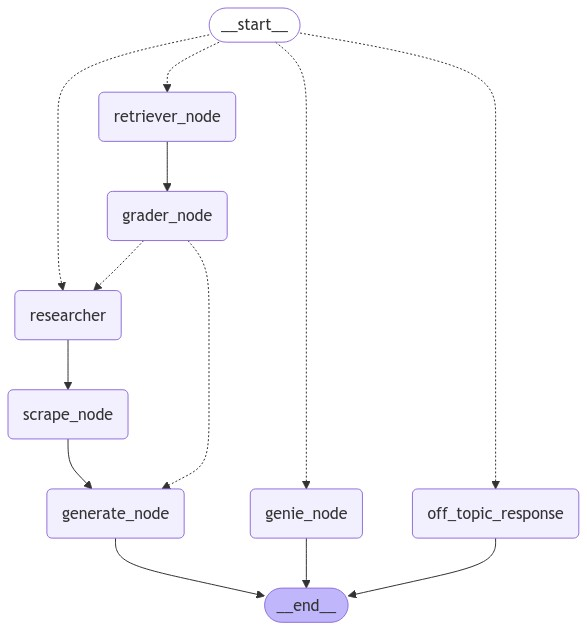

In [26]:
# Display the image
app.get_graph().draw_mermaid_png(output_file_path="graph.png")
display(Image(filename="graph.png"))

Try it out:

In [ ]:
# In which state in nigeria can you find the igbo-ukwu art?
# In what year did the benin art originate?
# Who founded Tosode Artin  Nupe Kingdom and in what year did they found it?
# How might a festival mask from the Ekpe society look if it were combined with Afrofuturistic technology and design?
# What would a contemporary reinterpretation of Yoruba beaded crowns look like if they were designed for futuristic monarchs?
# what's the latest on Nigerian cultures today?
# which art is refered to as court art?
# How might Igbo uli body art patterns appear if transformed into glowing, neon tattoos in a cityscape setting?

In [43]:
 # Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content=input("Query: "))]

# Run
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

Query: which art is refered to as court art?
ROUTING THIS QUERY APPROPRIATELY...
QUERY DATABASE.
RETRIEVING DOCUMENTS...
Improved Query: What traditional Nigerian art form, often associated with royal palaces and monarchies, is commonly referred to as "court art"?
Retrieved documents: ['TOPIC: -        History of Nigeria Traditional Art \nThe Nigerian traditional art discovered in Nigeria are Nok art, Igbo-ukwu art, \nIfe art, Benin Art, Esie art, Tosode art, and others. In these lesion six Art cultures \nwill be discussed. \nNOK Art this is the oldest art tradition in Nigeria it got its name from a village \ncalled Nok near Jeaa in Kaduna State close to Jos, Plateau State. The art culture was \ndiscovered by Clonel J. Dent Young a co-owner of a tin mining outfit around Nok in \n1928. \nThe artwork was taken to Jos Museum owned by the department of mining \nafter the second discovery in 1943. \nIGBO-UKWU Art is an art form discovered in a small village known as Igbo-\nukwu in Anambara 

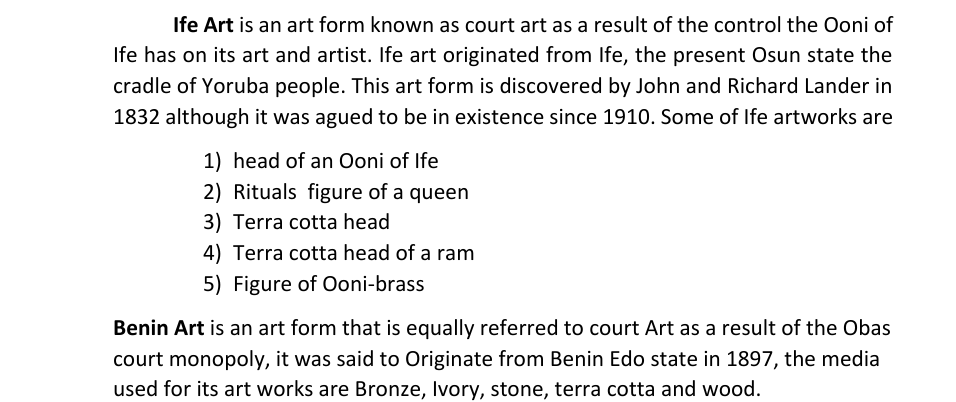

# Final Remarks:

Heritage is functioning well.

Looking ahead, I have several areas for improvement:

* I plan to explore enhanced embedding options, ideally using one of the state-of-the-art paid models. This should significantly enrich the augmented context, leading to improved hit rates and overall accuracy.

* I aim to develop a chatbot that offers a more conversational experience, moving beyond the rigid query-answer format that lacks state persistence. I believe this enhancement will greatly improve user engagement.

* I will rework the internet node to make it more robust for scraping content from various websites, enabling it to gather more extensive information. This aligns with my goal of enriching the augmented context and improving the accuracy of responses.

* I have concerns about Qdrant as the vector database for an agentic use case, particularly regarding stability and latency issues. Currently, users may encounter code errors during inference due to connection problems when querying the database, negatively affecting user experience. I will explore other database options or work on stabilizing the Qdrant connection to mitigate these frustrations.

* I believe that investing in more powerful generative API tools with multimodal capabilities could significantly enhance the project. OpenAI's SORA text-to-video model would be a fantastic addition for Heritage, offering new possibilities for user interaction and content creation.

### P.S.: 
--------------------------------------------------------------------------------------------------------------------------------------------------------


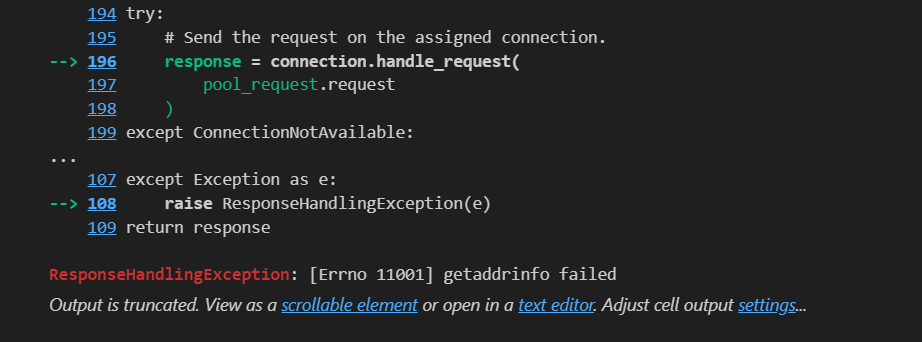

If you face the error above, just re-run the code block a few more times. I am open to suggestions on how to improve upon this in the future.